In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = env['cell_u']

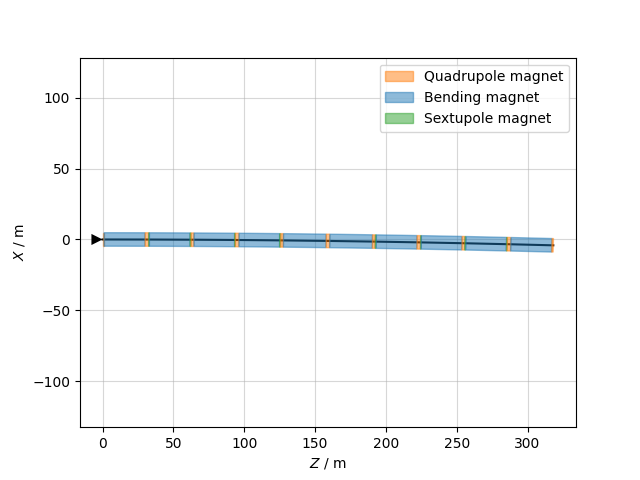

In [5]:
line.survey().plot()

In [6]:
tt = line.get_table(attr=True)
tt_quad = tt.rows[tt.element_type == 'Quadrupole']
tt_sext = tt.rows[tt.element_type == 'Sextupole']

tt_quad.cols['s length'].show()
tt_sext.cols['s length'].show()

name                s        length
qd1a::0             0          0.96
qf2a::0       30.1191          2.39
qd3a::0       62.5488          1.86
qf4a::0       93.7785           2.4
qd5a::0       125.768          1.83
qf6a          157.915          2.37
qd5a::1       190.601          1.83
qf4a::1       222.021           2.4
qd3a::1       253.791          1.86
qf2a::1        285.69          2.39
qd1a::1        317.24          0.96
name                s        length
sf2a::0       32.6591           0.3
sd1a::0       61.8788          0.52
sf1a::0       93.3285           0.3
sd2a::0       125.098          0.52
sd2a::1       192.581          0.52
sf1a::1       224.571           0.3
sd1a::1       255.801          0.52
sf2a::1        285.24           0.3


In [7]:
# Inspect one of the quads
line.info('qd1a')

Element of type:  Quadrupole
k1                  0.0                              vars['kqd1']   
k1s                 0.0                              None           
length              0.96                             vars['len_qd1']
num_multipole_kicks 0                                None           
order               5                                None           
inv_factorial_order 0.008333333333333333             None           
knl                 [0. 0. 0. 0. 0. 0.]              None           
ksl                 [0. 0. 0. 0. 0. 0.]              None           
edge_entry_active   0                                None           
edge_exit_active    0                                None           
_sin_rot_s          -999.0                           None           
_cos_rot_s          -999.0                           None           
_shift_x            0.0                              None           
_shift_y            0.0                              None           
_shif

In [8]:
kq_names = ['kqd1', 'kqf2', 'kqd3', 'kqf4', 'kqd5', 'kqf6']

In [9]:
line['kqd1'] = -1e-2
line['kqf2'] = 1e-2
line['kqd3'] = -1e-2
line['kqf4'] = 1e-2
line['kqd5'] = -1e-2
line['kqf6'] = 1e-2

### Match phase advance

In [10]:
opt_phase = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(kq_names, step=1e-4),
    targets=xt.TargetSet(mux=env['muxu'], muy=env['muyu'], at=xt.END, tol=1e-6)
)

In [11]:
opt_phase.target_status()

Target status:                          
id state tag     tol_met       residue   current_val    target_val description                                 
0  ON    END_mux   False     0.0138482      0.720098       0.70625 line=cell_u, ('mux', '_end_point'), val= ...
1  ON    END_muy   False      -0.37333      0.244081      0.617411 line=cell_u, ('muy', '_end_point'), val= ...


In [12]:
opt_phase.step(10)

                                             
Optimize - start penalty: 3.736         
Matching: model call n. 43               
Optimize - end penalty:  6.15189e-07


In [13]:
opt_phase.target_status()

Target status:                           
id state tag     tol_met       residue   current_val    target_val description                                 
0  ON    END_mux    True   1.57788e-09       0.70625       0.70625 line=cell_u, ('mux', '_end_point'), val= ...
1  ON    END_muy    True  -6.14986e-08      0.617411      0.617411 line=cell_u, ('muy', '_end_point'), val= ...


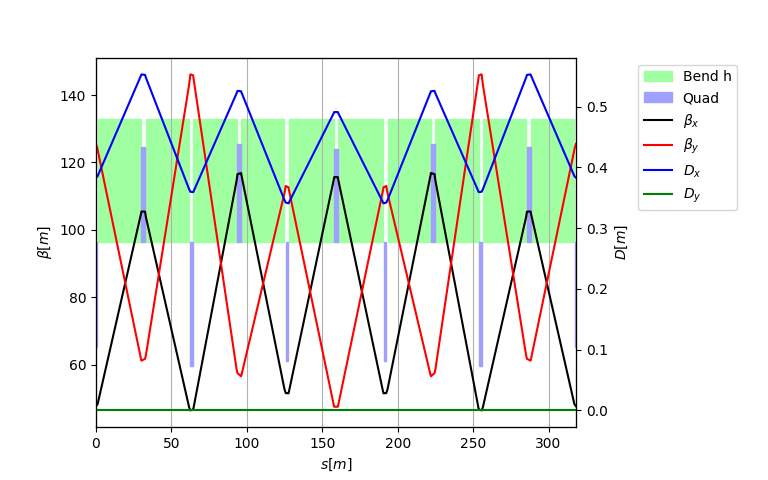

In [14]:
line.twiss4d().plot()

In [15]:
qf_entry = ['qf2a::0', 'qf4a::0', 'qf6a',    'qf4a::1', 'qf2a::1']
qd_entry = ['qd3a::0', 'qd5a::0', 'qd5a::1', 'qd3a::1', 'qd1a::1']

opt_cell = opt_phase.clone(name='phase + peaks',
    add_targets=[
        xt.Target(lambda tw: np.std(tw.rows[qf_entry].dx),   xt.LessThan(0.001), tag='dx',   tol=1e-3, weight=1000),
        xt.Target(lambda tw: np.std(tw.rows[qd_entry].bety), xt.LessThan(0.5), tag='bety', tol=1e-3, weight=1),
        xt.Target(lambda tw: np.std(tw.rows[qf_entry].betx), xt.LessThan(0.5), tag='betx', tol=1e-3, weight=1),
])

In [16]:
opt_cell.run_simplex(1000)

In [17]:
opt_cell.log()

Table: 2 rows, 21 cols
iteration                   penalty alpha tag     tol_met target_active hit_limits vary_active ...
0                           26.5475    -1         yynnn   yyyyy         nnnnnn     yyyyyy     
1                       1.13775e-05    -1 simplex yyyyy   yyyyy         nnnnnn     yyyyyy     

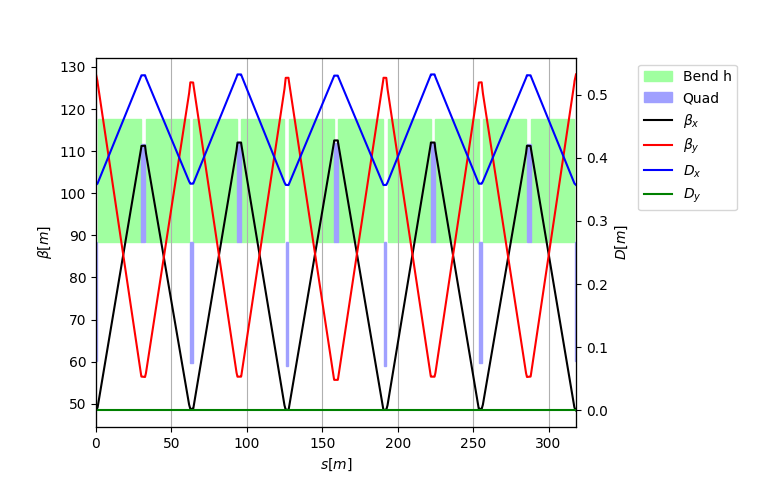

In [18]:
opt_cell.plot()

In [19]:
strengths = opt_cell.get_knob_values()

In [20]:
strengths

{'kqd1': -0.01334474827291482,
 'kqf2': 0.011127287518356527,
 'kqd3': -0.0135697985380165,
 'kqf4': 0.011200967437582908,
 'kqd5': -0.013865153275613194,
 'kqf6': 0.011186182312800396}

In [21]:
xt.json.dump(strengths, 'strengths_quads_00_arc_cell.json')

In [23]:
!open strengths_quads_00_arc_cell.json